<a href="https://colab.research.google.com/github/zhintappp/Discover-Batik-Machine-Learning/blob/main/Discover_Batik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile,os
import cv2
import tensorflow as tf
import shutil

from google.colab.patches import cv2_imshow
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow_hub as hub

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"haha123415234","key":"9d88992ebc93ae20c3845562a70fa261"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dionisiusdh/indonesian-batik-motifs

 99% 259M/262M [00:02<00:00, 106MB/s]
100% 262M/262M [00:02<00:00, 122MB/s]


In [5]:
local_zip = 'indonesian-batik-motifs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('dataset')
zip_ref.close()

In [6]:
main_dir = 'dataset'

data = []
for dir in os.listdir(main_dir):
    for item in os.listdir(str(main_dir)+'/'+str(dir)):
        path = 'dataset/'+str(dir)+'/'+str(item)
        label = dir
        data.append([str(path),label])

In [7]:
df = pd.DataFrame(data, columns=['item','label'])
df

,item,label
0,dataset/batik-sekar/5.jpg,batik-sekar
1,dataset/batik-sekar/13.jpg,batik-sekar
2,dataset/batik-sekar/40.jpg,batik-sekar
3,dataset/batik-sekar/7.jpg,batik-sekar
4,dataset/batik-sekar/49.jpg,batik-sekar
...,...,...
978,dataset/batik-tambal/9.jpg,batik-tambal
979,dataset/batik-tambal/39.jpg,batik-tambal
980,dataset/batik-tambal/15.jpg,batik-tambal
981,dataset/batik-tambal/47.jpg,batik-tambal


from matplotlib import pyplot as plt
df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [8]:
enc = LabelEncoder()
enc.fit(df['label'])
df['label'] = enc.transform(df['label'])

In [9]:
dim = (224, 224)
channel = (3, )
input_shape = dim + channel

In [10]:
arr = df.to_numpy()

x = []
y = []
for i in tqdm(range(len(arr))):
    try:
        image_source = arr[i][0]
        img = image.load_img(image_source, target_size=dim)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        raw = np.vstack([img_array])
        x.append(list(raw.flatten()))
        y.append(arr[i][1])
    except:pass

  0%|          | 0/983 [00:00<?, ?it/s]

In [11]:
X = []
for i in tqdm(range(len(x))):
    x_raw = np.array(x[i]).reshape(input_shape)
    X.append(x_raw)

  0%|          | 0/981 [00:00<?, ?it/s]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=300)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [13]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
feature_extractor = hub.KerasLayer(module_url, input_shape = (224,224,3), trainable=False)

In [15]:
# modelling starts using a CNN.

model = Sequential()
feature_extractor

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters =64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(20, activation = "softmax"))

In [16]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train, epochs=48, validation_data =(X_test, y_test))

Epoch 1/48
16/16 [==============================] - 43s 3s/step - loss: 0.0428 - accuracy: 0.9857 - val_loss: 4.6107 - val_accuracy: 0.1466
Epoch 2/48
16/16 [==============================] - 44s 3s/step - loss: 0.0421 - accuracy: 0.9898 - val_loss: 4.4203 - val_accuracy: 0.1629
Epoch 3/48
16/16 [==============================] - 43s 3s/step - loss: 0.0342 - accuracy: 0.9857 - val_loss: 5.7516 - val_accuracy: 0.1405
Epoch 4/48
16/16 [==============================] - 43s 3s/step - loss: 0.0490 - accuracy: 0.9878 - val_loss: 4.9287 - val_accuracy: 0.1548
Epoch 5/48
16/16 [==============================] - 43s 3s/step - loss: 0.0398 - accuracy: 0.9837 - val_loss: 5.9124 - val_accuracy: 0.1181
Epoch 6/48
16/16 [==============================] - 42s 3s/step - loss: 0.0329 - accuracy: 0.9857 - val_loss: 5.0827 - val_accuracy: 0.1426
Epoch 7/48
16/16 [==============================] - 42s 3s/step - loss: 0.0361 - accuracy: 0.9898 - val_loss: 4.3848 - val_accuracy: 0.1589
Epoch 8/48
16/16 [==

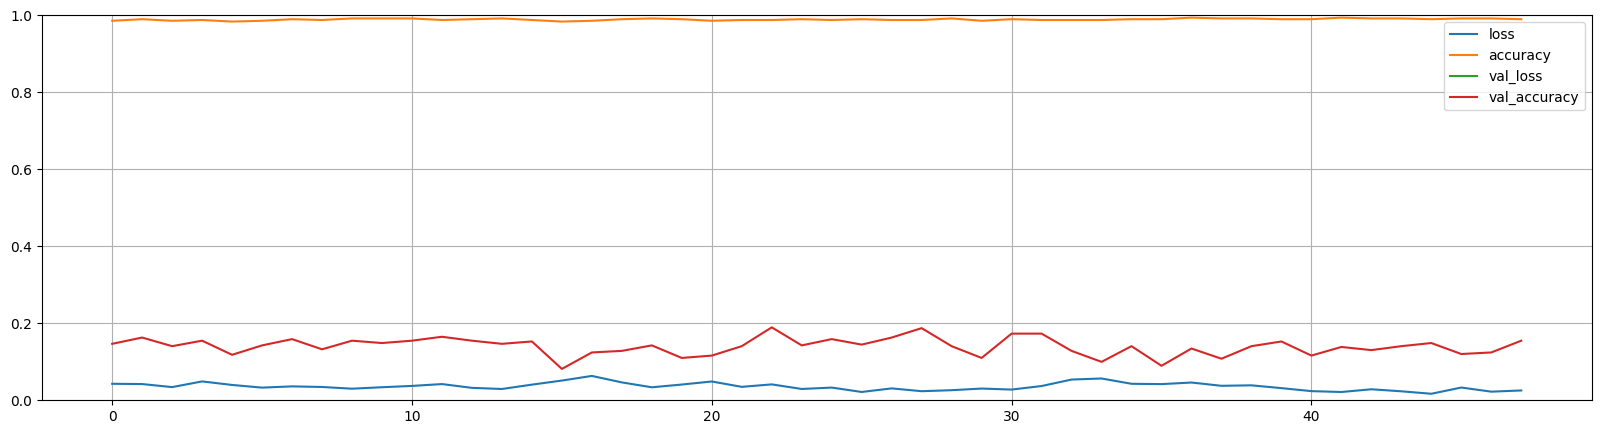

In [21]:
pd.DataFrame(history.history).plot(figsize=(20, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [23]:
# getting predictions on val set.
pred=model.predict(X_test)
pred_digits=np.argmax(pred,axis=1)

16/16 [==============================] - 9s 562ms/step


In [24]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

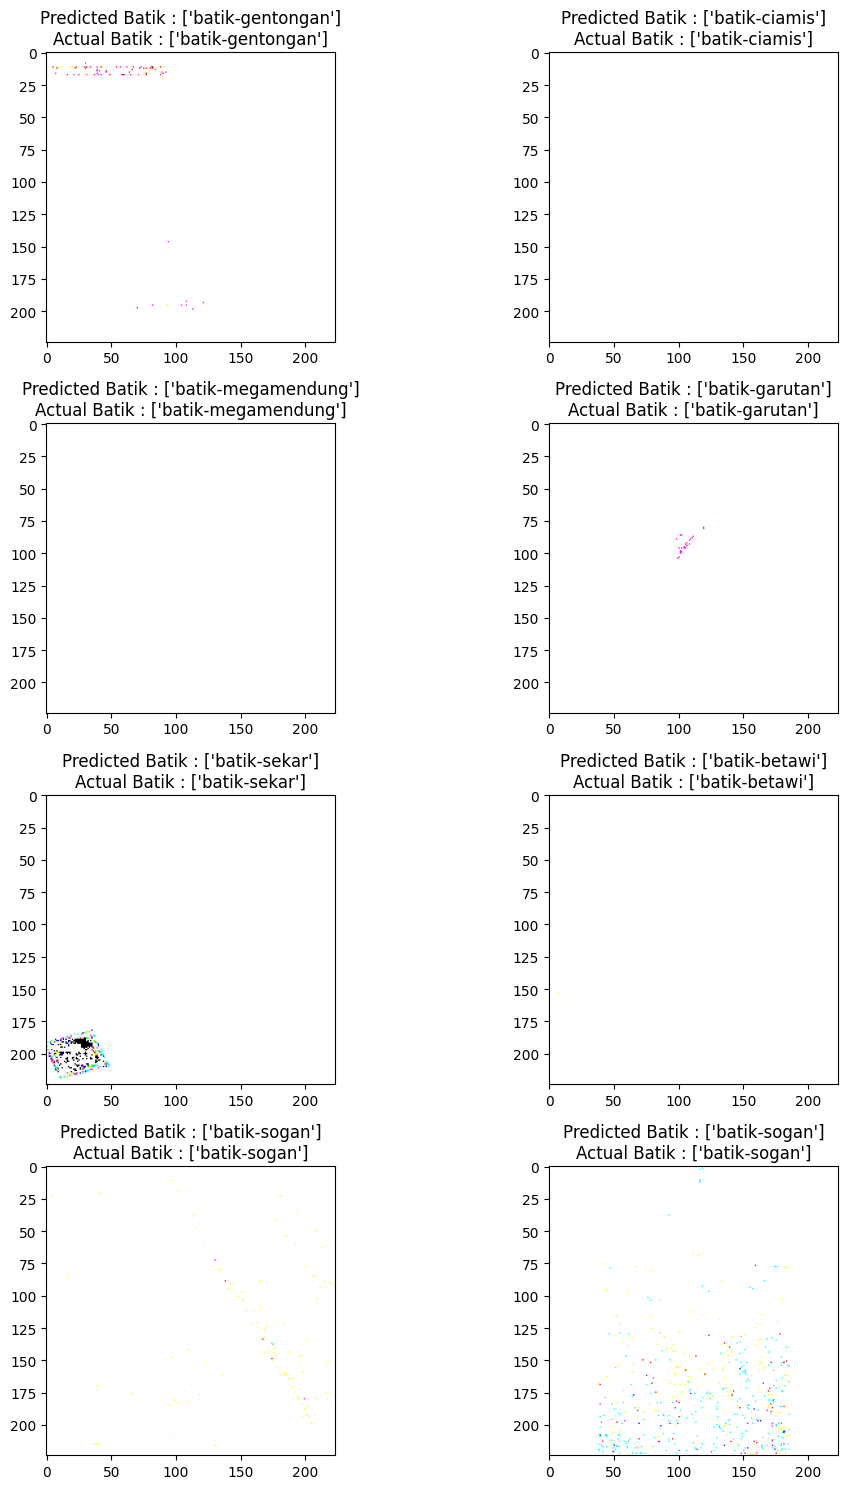

In [29]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[prop_class[count]])
        ax[i,j].set_title("Predicted Batik : "
                          +str(enc.inverse_transform([pred_digits[prop_class[count]]]))
                          +"\n"+"Actual Batik : "
                          +str(enc.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

In [32]:
!mkdir -p saved_model
model.save('Model_batik.h5')